<div style = "text-align:center;">
    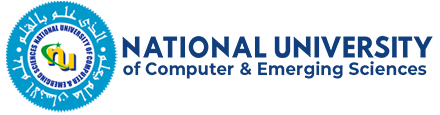
</div>

<h1 style = "text-align:center; color:#2c3e50; font-size:40px; font-weight:bold; margin-bottom:20px;">Star points detection and image Generation</h1>

<h2 style = "text-align:center; color:#34495e; font-size:30px; margin-top:30px;">Machine Learning Lab</h2>

<h2 style = "text-align:center; color:#34495e; font-size:30px; margin-top:30px;">Sir Usama</h2>

<h1 style = "text-align:center; color:#2c3e50; font-size:40px; margin-bottom:20px;">Group Members</h1>

<table style = "width:80%; margin:0 auto; border-collapse:collapse; box-shadow:0 4px 8px rgba(0, 0, 0, 0.1); background-color:#fff; border-radius:8px; overflow:hidden;">
    <thead>
        <tr style = "background-color:#3498db; color:white; font-weight:bold; font-size:28px">
            <th style = "border:1px solid #ddd; padding:12px; text-align:center;">Name</th>
            <th style = "border:1px solid #ddd; padding:12px; text-align:center;">Roll Number</th>
            <th style = "border:1px solid #ddd; padding:12px; text-align:center;">Section</th>
        </tr>
    </thead>
    <tbody>
        <tr style = "background-color:#f9f9f9; font-size:18px">
            <td style = "border:1px solid #ddd; padding:12px; text-align:center;">Maisum Abbas</td>
            <td style = "border:1px solid #ddd; padding:12px; text-align:center;">22K - 4129</td>
            <td style = "border:1px solid #ddd; padding:12px; text-align:center;">BAI - 5A</td>
        </tr>
        <tr style = "background-color:#f2f2f2; font-size:18px">
            <td style = "border:1px solid #ddd; padding:12px; text-align:center;">Basim Baqai</td>
            <td style = "border:1px solid #ddd; padding:12px; text-align:center;">22K - 4062</td>
            <td style = "border:1px solid #ddd; padding:12px; text-align:center;">BAI - 5A</td>
        </tr>
        <tr style = "background-color:#f9f9f9; font-size:18px">
            <td style = "border:1px solid #ddd; padding:12px; text-align:center;">Abdul Rehman</td>
            <td style = "border:1px solid #ddd; padding:12px; text-align:center;">22K - 4078</td>
            <td style = "border:1px solid #ddd; padding:12px; text-align:center;">BAI - 5A</td>
        </tr>
    </tbody>
</table>


# Mounting Drive


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Showing sample images from the Dataset

Enter the number of star images to display: 5


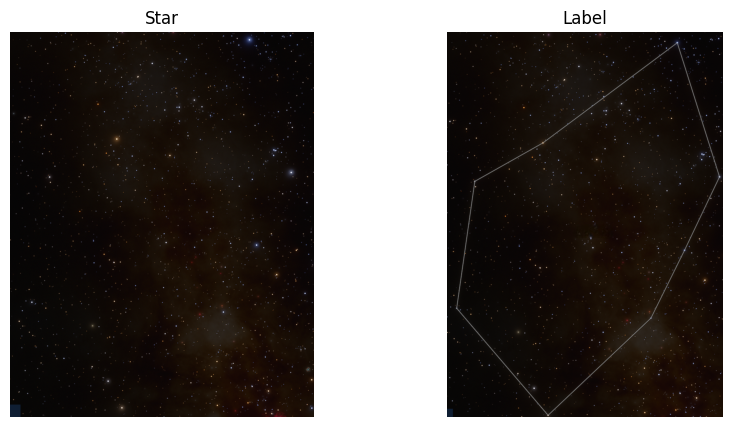

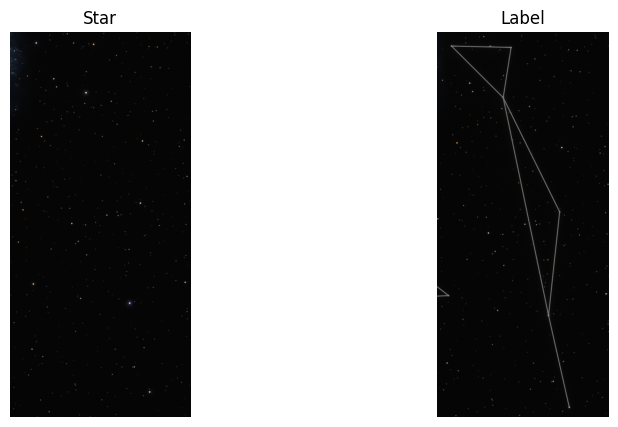

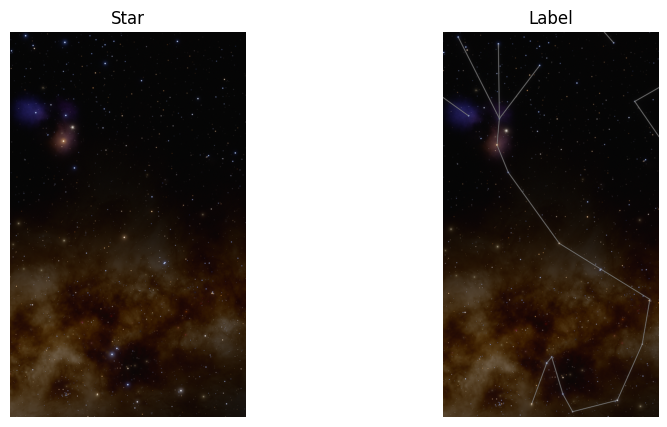

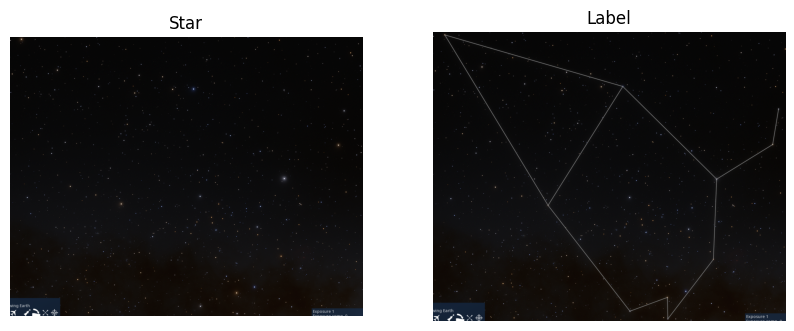

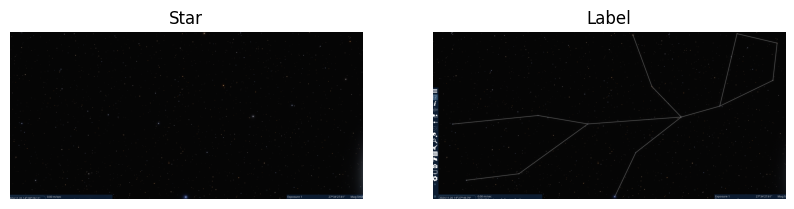

In [2]:
import os
import cv2
import matplotlib.pyplot as plt

# Set paths to the dataset folders
dataset_path = "/content/drive/MyDrive/Constellation Datasest"
stars_folder = os.path.join(dataset_path, "stars")
labels_folder = os.path.join(dataset_path, "labels")

# Get the list of image files in both folders
stars_files = sorted([f for f in os.listdir(stars_folder) if f.endswith(('.jpg', '.png', '.jpeg'))])
labels_files = sorted([f for f in os.listdir(labels_folder) if f.endswith(('.jpg', '.png', '.jpeg'))])

# Check if both folders have images and are matched
if len(stars_files) != len(labels_files):
    print("Warning: Number of images in 'stars' and 'labels' folders do not match!")

# Option to show a limited number of stars
num_stars_to_show = int(input("Enter the number of star images to display: "))
num_stars_to_show = min(num_stars_to_show, len(stars_files), len(labels_files))

# Display images side-by-side
for i, (star_file, label_file) in enumerate(zip(stars_files, labels_files)):
    if i >= num_stars_to_show:
        break

    star_path = os.path.join(stars_folder, star_file)
    label_path = os.path.join(labels_folder, label_file)

    # Load the images
    star_image = cv2.imread(star_path)
    label_image = cv2.imread(label_path)

    # Convert BGR to RGB for proper color display
    star_image = cv2.cvtColor(star_image, cv2.COLOR_BGR2RGB)
    label_image = cv2.cvtColor(label_image, cv2.COLOR_BGR2RGB)

    # Plot the images
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title("Star")
    plt.imshow(star_image)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Label")
    plt.imshow(label_image)
    plt.axis("off")

    plt.show()


# Connecting Star points Using Nearest Neighbours

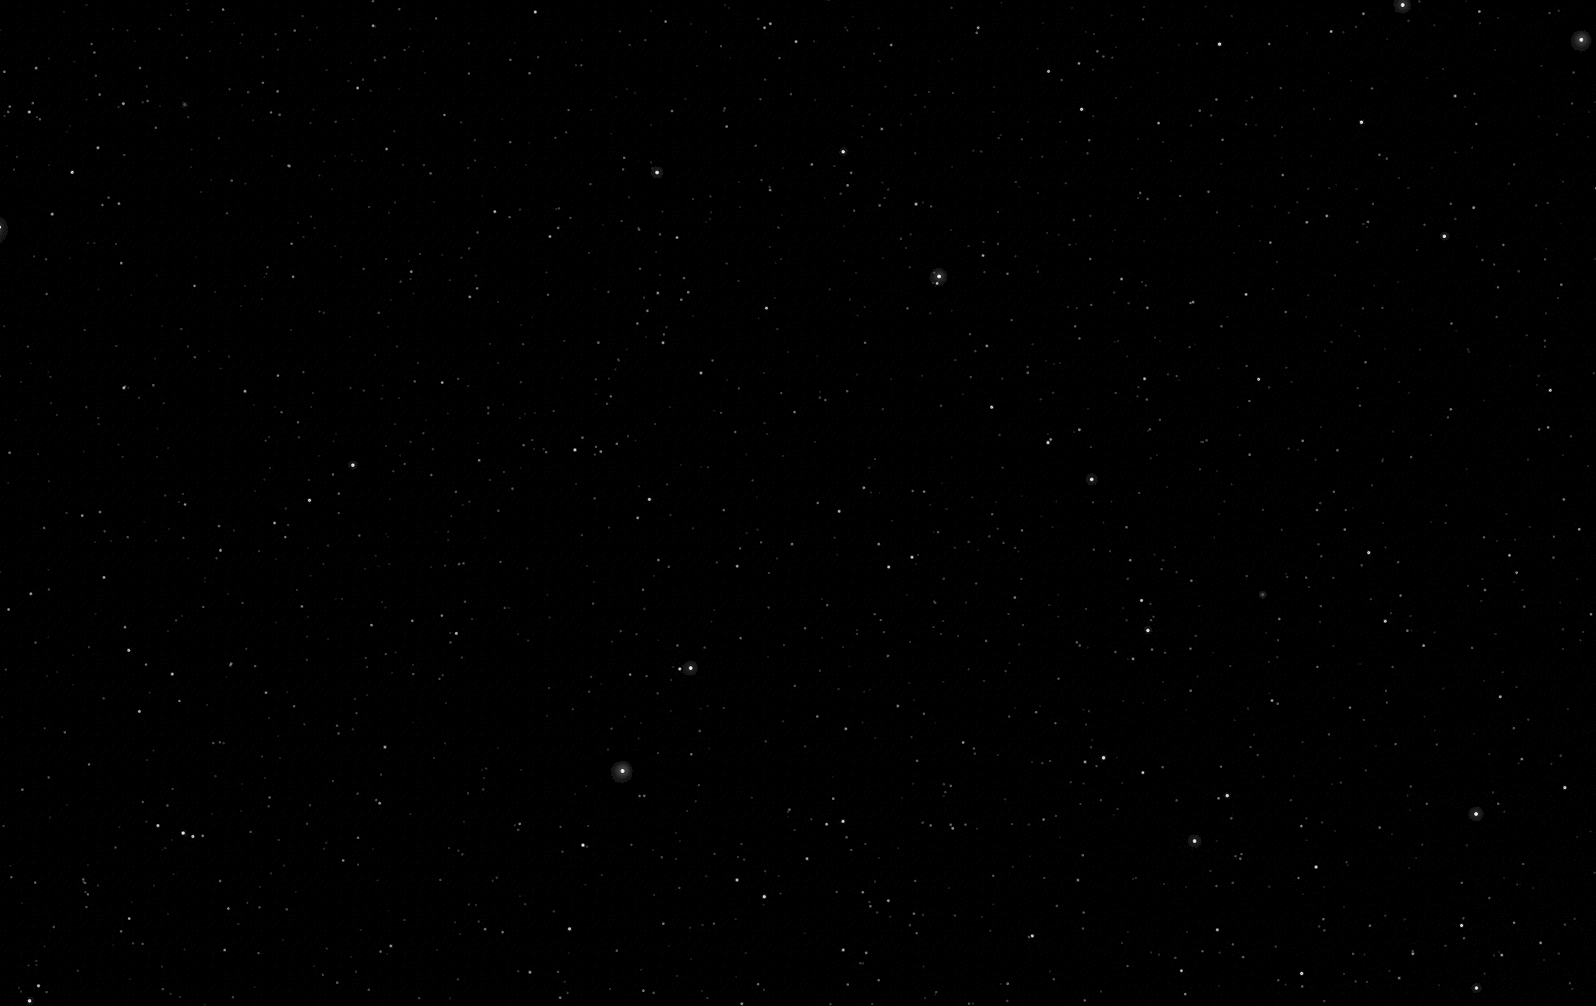

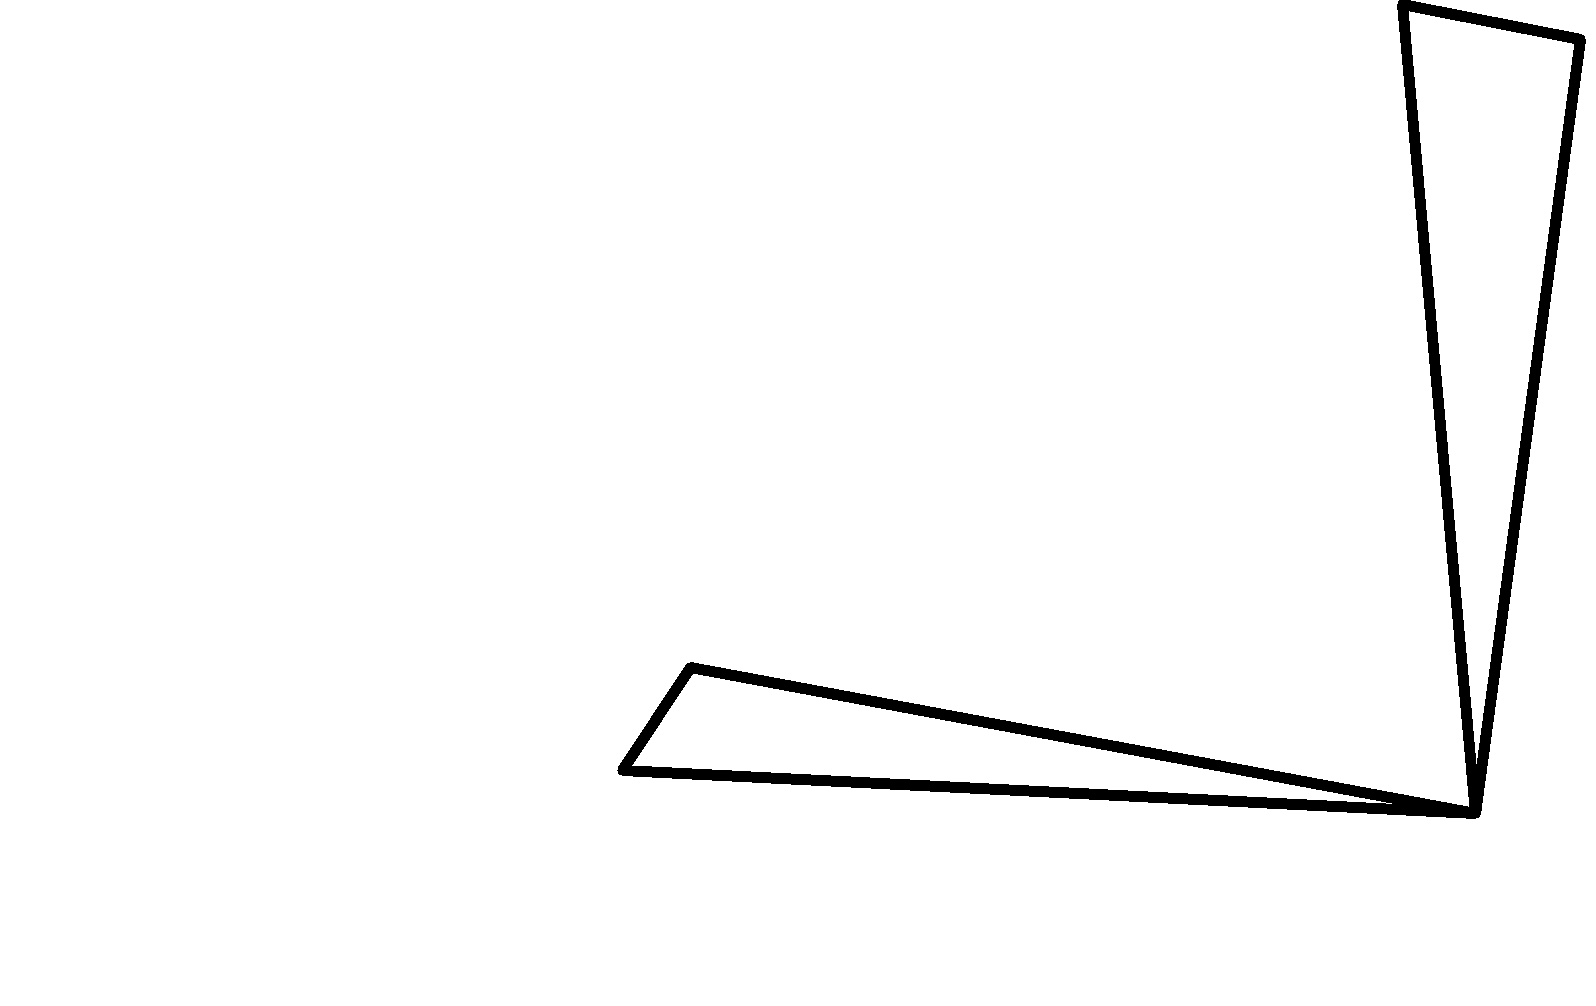

True

In [8]:
import cv2
import numpy as np
from sklearn.neighbors import NearestNeighbors
from google.colab.patches import cv2_imshow

# Upload an image

image_path = "/content/drive/MyDrive/Constellation Datasest/stars/76.png"  # Get the uploaded file name

# Load the image
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Threshold the image to find contours
_, thresh = cv2.threshold(image, 230, 255, cv2.THRESH_BINARY)

# Find contours
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Extract contour centers
contour_centers = []
for contour in contours:
    M = cv2.moments(contour)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        contour_centers.append((cx, cy))

# Convert contour centers to numpy array
contour_centers = np.array(contour_centers)

# Perform K-Nearest Neighbors to find connections
knn = NearestNeighbors(n_neighbors=3)  # 2 includes the point itself
knn.fit(contour_centers)
connections = knn.kneighbors(contour_centers, return_distance=False)

# Create a black image to visualize connections
height, width = image.shape
black_image = np.ones((height, width, 3), dtype=np.uint8) * 255

# Draw connections
for i, neighbors in enumerate(connections):
    point1 = contour_centers[i]
    for neighbor_index in neighbors[1:]:  # Skip the first neighbor (itself)
        point2 = contour_centers[neighbor_index]
        cv2.line(black_image, tuple(point1), tuple(point2), (0, 0, 0), 10)

# Display the result
cv2_imshow(image)
cv2_imshow(black_image)

# Save the result
cv2.imwrite("connections_result.jpg", black_image)

# Streamlit Graphical Interface

In [4]:
import streamlit as st
import cv2
import numpy as np
from sklearn.neighbors import NearestNeighbors
from PIL import Image

# Function to process the image
def process_image(image_path, threshold_value, n_neighbors):
    # Load the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Threshold the image to find contours
    _, thresh = cv2.threshold(image, threshold_value, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Extract contour centers
    contour_centers = []
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            contour_centers.append((cx, cy))

    # Convert contour centers to numpy array
    contour_centers = np.array(contour_centers)

    # Perform K-Nearest Neighbors to find connections
    knn = NearestNeighbors(n_neighbors=n_neighbors)
    knn.fit(contour_centers)
    connections = knn.kneighbors(contour_centers, return_distance=False)

    # Create a black image to visualize connections
    height, width = image.shape
    black_image = np.ones((height, width, 3), dtype=np.uint8) * 255

    # Draw connections
    for i, neighbors in enumerate(connections):
        point1 = contour_centers[i]
        for neighbor_index in neighbors[1:]:  # Skip the first neighbor (itself)
            point2 = contour_centers[neighbor_index]
            cv2.line(black_image, tuple(point1), tuple(point2), (0, 0, 0), 10)

    return image, black_image

# Streamlit UI
def main():
    st.title("Constellation Finder")

    # File uploader
    uploaded_file = st.file_uploader("Upload an Image", type=["png", "jpg", "jpeg"])

    if uploaded_file is not None:
        # Load the uploaded image
        image_path = uploaded_file.name
        with open(image_path, "wb") as f:
            f.write(uploaded_file.getbuffer())

        # Threshold slider
        threshold_value = st.slider("Threshold Value", min_value=0, max_value=255, value=230, step=1)

        # Number of neighbors slider
        n_neighbors = st.slider("Number of Neighbors", min_value=2, max_value=10, value=3, step=1)

        # Process the image
        original_image, processed_image = process_image(image_path, threshold_value, n_neighbors)

        # Display the images side by side
        col1, col2 = st.columns(2)
        with col1:
            st.image(original_image, caption="Original Image", use_column_width=True, channels="GRAY")
        with col2:
            st.image(processed_image, caption="Processed Image", use_column_width=True)

if __name__ == "__main__":
    main()


ModuleNotFoundError: No module named 'streamlit'

In [ ]:
!streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py

# Abstract Art Image Generation

In [9]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
from PIL import Image
import torch
import numpy as np
import cv2

# Step 1: Load Skeleton Image
input_image_path = "/content/connections_result.jpg"  # Replace with your skeleton
input_image = Image.open(input_image_path).convert("RGB")
input_image = input_image.resize((512, 512))  # Resize for the model

# Step 2: Convert Skeleton to a Conditional Image (Edges)
skeleton_np = np.array(input_image)
edges = cv2.Canny(skeleton_np, 100, 200)  # Edge detection
edges_img = Image.fromarray(edges)

# Step 3: Load Pretrained ControlNet and Stable Diffusion
controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11p_sd15_canny", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16)
pipe.to("cuda")  #Use GPU for faster processing

# Step 4: Generate the Output Based on the Skeleton
prompt = "abstract art"
output = pipe(prompt, image=edges_img, num_inference_steps=50).images[0]

# Step 5: Save or Display the Result
output.save("output.png")
output.show()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]